In [147]:
import cv2
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

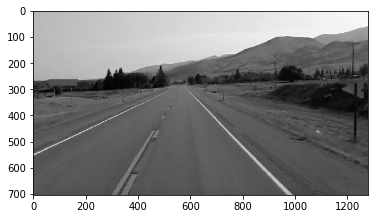

In [148]:
def gray_scale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

image = mpimg.imread('test_image.jpg')
# Changing 4 Channel image to 3 Channel
if image.shape[2] == 4:
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
gray_image = grayscale(image)
plt.imshow(gray_image, cmap='gray')

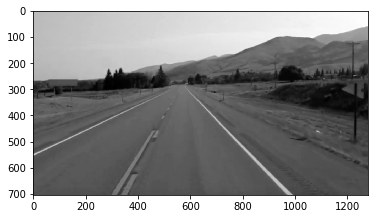

In [149]:
def gaussian_blur(img):
    # Reducing Noise in Image using Gaussian Blur
    return cv2.GaussianBlur(img, (5, 5), 0)

blur_image = gaussian_blur(gray_image)
plt.imshow(blur_image, cmap='gray')

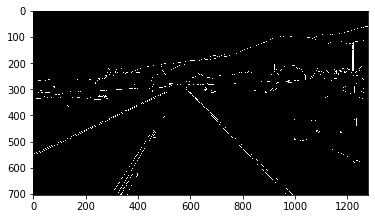

In [150]:
def canny(img):
    return cv2.Canny(img, 50, 100)

canny_image = canny(blur_image)
plt.imshow(canny_image, cmap='gray')

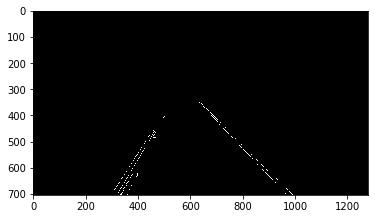

In [151]:
def region_of_interest(img, polygon):
    # Only keeping the region of the image defined by the polygon
    # Defining a blank mask, of image size, to start with
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, polygon, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)    
    return masked_image
  
#apply mask
height = image.shape[0]
width = image.shape[1]
    
polygon = np.array([[(200, height), (500, height * 0.5), (700, height * 0.5), (width - 200, height)]], dtype=np.int32)

masked_image = region_of_interest(canny_image, polygon)
plt.imshow(masked_image, cmap='gray')

In [152]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)    
    return line_img

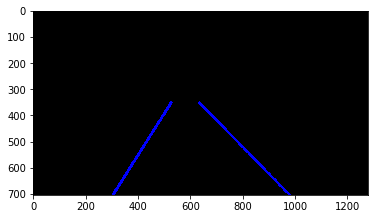

In [153]:
def draw_lines(img, lines):
    color = [0, 0, 255]
    thickness = 10
    
    # these variables represent the y-axis coordinates to which the line will be extrapolated to
    ymin_global = img.shape[0]
    ymax_global = img.shape[0]
    
    # left lane line variables
    all_left_slope = []
    all_left_y = []
    all_left_x = []
    
    # right lane line variables
    all_right_slope = []
    all_right_y = []
    all_right_x = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
            ymin_global = min(min(y1, y2), ymin_global)
            
            if (slope > 0):
                all_left_slope.append(slope)
                all_left_y.append((y1, y2))
                all_left_x.append((x1, x2))
            else:
                all_right_slope.append(slope)
                all_right_y.append((y1, y2))
                all_right_x.append((x1, x2))
    
    avg_left_slope = np.mean(all_left_slope)
    avg_y_left = np.mean(all_left_y)
    avg_x_left = np.mean(all_left_x)
    left_intercept = avg_y_left - (avg_left_slope * avg_x_left)
    
    avg_right_slope = np.mean(all_right_slope)
    avg_y_right = np.mean(all_right_y)
    avg_x_right = np.mean(all_right_x)
    right_intercept = avg_y_right - (avg_right_slope * avg_x_right)
    
    # Make sure we have some points in each lane line category
    if ((len(all_left_slope) > 0) and (len(all_right_slope) > 0)):
        upper_left_x = int((ymin_global - left_intercept) / avg_left_slope)
        lower_left_x = int((ymax_global - left_intercept) / avg_left_slope)
        upper_right_x = int((ymin_global - right_intercept) / avg_right_slope)
        lower_right_x = int((ymax_global - right_intercept) / avg_right_slope)

        cv2.line(img, (upper_left_x, ymin_global), (lower_left_x, ymax_global), color, thickness)
        cv2.line(img, (upper_right_x, ymin_global), (lower_right_x, ymax_global), color, thickness)
        
hough_line_image = hough_lines(masked_image, 1, np.pi/180, 100, 40, 5)
plt.imshow(hough_line_image, cmap='gray')

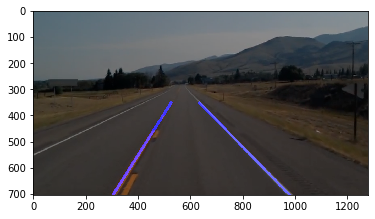

In [154]:
def weighted_image(img, alpha, hough_line_image, beta, lam):
    return cv2.addWeighted(img, alpha, hough_line_image, beta, lam)

combined_image = weighted_image(image, 0.6, hough_line_image, 1, 0)
plt.imshow(combined_image)

In [155]:
def process_frame(frame):
    gray_frame = gray_scale(frame)
    blur_frame = gaussian_blur(gray_frame)
    canny_frame = canny(blur_frame)

    #apply mask
    height = frame.shape[0]
    width = frame.shape[1]
    
    polygon = np.array([[(200, height), (500, height * 0.5), (700, height * 0.5), (width - 200, height)]], dtype=np.int32)
    
    masked_frame = region_of_interest(canny_frame, polygon)

    hough_line_frame = hough_lines(masked_frame, 1, np.pi/180, 100, 30, 5)

    combined_frame = weighted_image(frame, 0.6, hough_line_frame, 1, 0)
    return combined_frame

output = 'lane_detection.mp4'
clip1 = VideoFileClip('test_video.mp4')
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(output, audio=False)

Moviepy - Building video lane_detection.mp4.
Moviepy - Writing video lane_detection.mp4



Moviepy - Done !
Moviepy - video ready lane_detection.mp4
Wall time: 45.9 s


In [157]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))